# Data
The data for this analysis comes from the Kaggle dataset "Breast Cancer Proteomes", available at https://www.kaggle.com/piotrgrabo/breastcancerproteomes. It caught my attention because I was doing a survival analysis for work, and it also had paired mRNA/proteome data, which will hopefully provide some biological depth into the insights.

# Analysis

In [28]:
# Load python libraries
import numpy as np
import pandas as pd
import lifelines as ll

# Plotting helpers
from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette(sns.color_palette('muted'))
palette = {
    'green' : sns.color_palette('muted')[2],
    'red'   : sns.color_palette('muted')[3],
    'black' : sns.light_palette('black')[-2],
    'gray'  : sns.light_palette('black')[-3],
    'blue'  : sns.color_palette('muted')[0],
    }

plt.style.use(
    'seaborn-whitegrid'
    #'seaborn-muted'
)
#from pylab import rcParams
#rcParams['figure.figsize']=10, 5

import warnings
warnings.filterwarnings('ignore') #sns.distplot

In [4]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import logrank_test
from lifelines.plotting import plot_lifetimes

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

### Data preprocessing

In [6]:
na_values = ["Indeterminate", "Equivocal"]
clinical = pd.read_csv('./data/breast_cancer/clinical_data_breast_cancer.csv', index_col=0, na_values=na_values)

In [7]:
def recode_yn(s):
    """Recode boolean variables to 0/1"""
    if pd.isna(s):
        return np.nan
    elif isinstance (s, str):
        if s in ["Positive", "T_Other"]:
            return 1
        elif s in ["Negative", "T1"]:
            return 0
    else:
        print("Could not convert: ",s, ". Returning nan")
        return np.nan

In [8]:
clinical['ER Status'] = clinical['ER Status'].apply(recode_yn)
clinical['PR Status'] = clinical['PR Status'].apply(recode_yn)
clinical['HER2 Final Status'] = clinical['HER2 Final Status'].apply(recode_yn)
clinical['Metastasis-Coded'] = clinical['Metastasis-Coded'].apply(recode_yn)
clinical['Tumor--T1 Coded'] = clinical['Tumor--T1 Coded'].apply(recode_yn)
clinical = clinical.drop_duplicates()

In [9]:
clinical.sample(10)

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-BH-A0EE,FEMALE,68,0.0,0,1.0,T3,1,N0,Negative,M0,...,HER2-enriched,-9,-11,7,1,Basal,5,1,2,3
TCGA-AR-A0TY,FEMALE,54,1.0,0,0.0,T2,1,N0,Negative,M0,...,Luminal B,-5,-2,4,4,LumA/B,1,4,1,1
TCGA-AN-A0AL,FEMALE,41,0.0,0,0.0,T4,1,N0,Negative,M0,...,Basal-like,0,-13,3,5,Basal,1,2,2,2
TCGA-A2-A0YF,FEMALE,67,1.0,0,0.0,T1,0,N0,Negative,M0,...,Luminal A,-3,-12,1,2,ReacII,2,3,3,3
TCGA-BH-A0E1,FEMALE,52,1.0,1,0.0,T2,1,N1,Positive,M0,...,Luminal A,-3,-12,6,2,ReacII,2,3,3,3
TCGA-AO-A0J9,FEMALE,61,1.0,1,0.0,T2,1,N3,Positive,M0,...,Luminal A,-3,-2,2,4,ReacI,2,3,1,4
TCGA-BH-A18Q,FEMALE,56,0.0,0,0.0,T2,1,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,0.0,0,0.0,T3,1,N0,Negative,M0,...,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-BH-A0AV,FEMALE,52,0.0,0,0.0,T1,0,N0,Negative,M0,...,Basal-like,0,-13,4,5,ReacII,1,2,2,2


In [10]:
# Prepare data-specific pallette
palette_mrna = {k:v for k,v in zip(clinical["PAM50 mRNA"].sort_values().unique(), sns.color_palette("muted")[:len(clinical["PAM50 mRNA"].unique())])}


# Descriptive
I'll start with some descriptive statistics and visualizations to gain familiarity with the data.

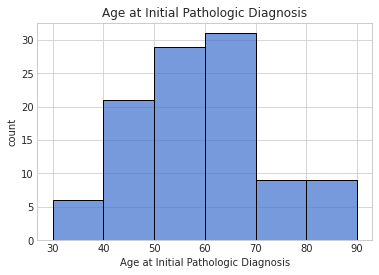

In [12]:
sns.histplot(x=clinical['Age at Initial Pathologic Diagnosis'], bins=[30,40,50,60,70,80,90])
plt.ylabel("count")
plt.title("Age at Initial Pathologic Diagnosis")
plt.show()

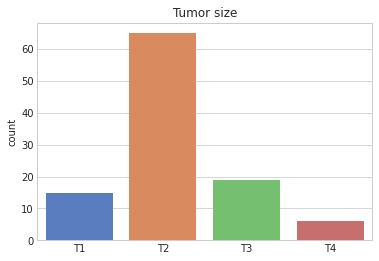

In [13]:
sns.countplot(x=sorted(clinical['Tumor']))
plt.title("Tumor size")
plt.show()

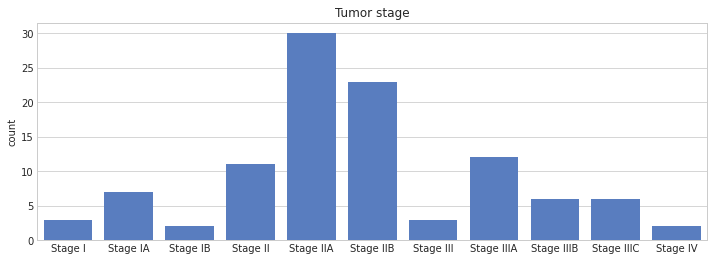

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(x=sorted(clinical['AJCC Stage']), color=palette["blue"], ax=ax)
plt.title("Tumor stage")
plt.show()

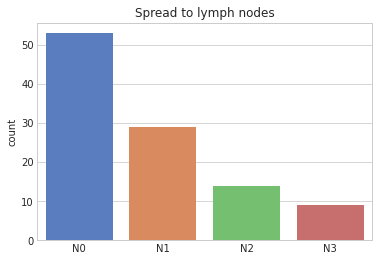

In [15]:
sns.countplot(x=sorted(clinical['Node']))
plt.title("Spread to lymph nodes")
plt.show()

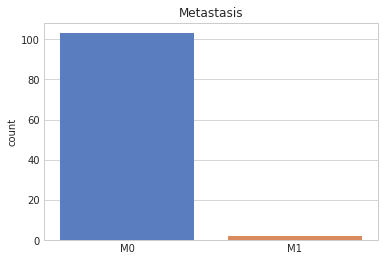

In [16]:
sns.countplot(x=sorted(clinical['Metastasis']))
plt.title("Metastasis")
plt.show()

### Structure in the clinical data
Show that Tumor, Node, and AJCC Stage are correlated

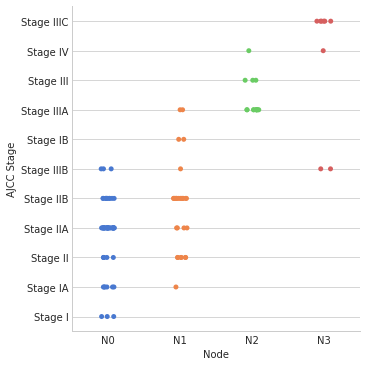

In [29]:
sns.catplot(y="AJCC Stage", x="Node", data=clinical.sort_values(["AJCC Stage", "Tumor"]))
plt.show()

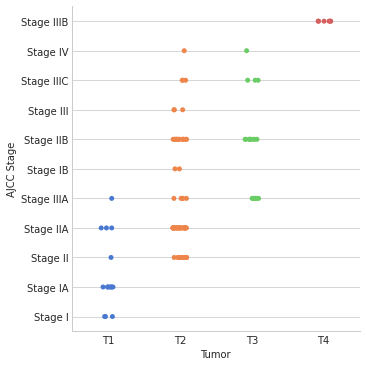

In [30]:
sns.catplot(y="AJCC Stage", x="Tumor", data=clinical.sort_values(["AJCC Stage", "Tumor"]))
plt.show()

### Survival - exploratory / visuzlizations

In [21]:
from lifelines.plotting import plot_lifetimes

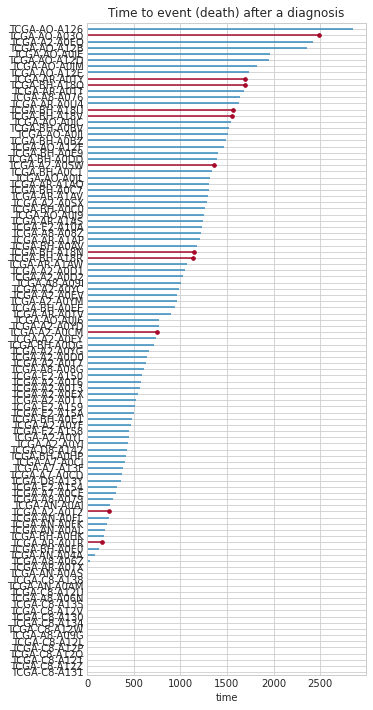

In [31]:
fig = plt.figure(figsize=(5,12))
ax = plot_lifetimes(clinical["OS Time"], event_observed=clinical["OS event"])
ax.set_xlabel("time")
ax.set_title("Time to event (death) after a diagnosis")
plt.show()

What is the overall survival line for the whole population?

In [23]:
kmf = KaplanMeierFitter()
T = clinical["OS Time"]
E = clinical["OS event"]
kmf.fit(T, event_observed=E, label="All patients")

<lifelines.KaplanMeierFitter:"All patients", fitted with 105 total observations, 94 right-censored observations>

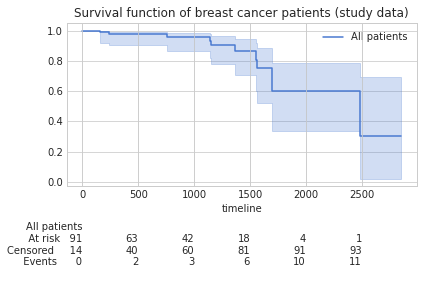

In [24]:
kmf.plot_survival_function(at_risk_counts=True)
plt.title('Survival function of breast cancer patients (study data)');
# TODO shaded area is CI, add this to the legend

From the count table we can see that there are only about 10% events at the end of the study. I guess that's good, since it means that in the real world fewer people died? But we're going to have a harder time analysing this data than if there were more events.

### H0: The PAM50 mRNA groups are different in survival
Since the PAM50 m RNA variable is not ordinal, my opinion is that the use of a pairwise comparison of Kaplan-Meier curves is more appropriate. Let's take a look on how much data there is:

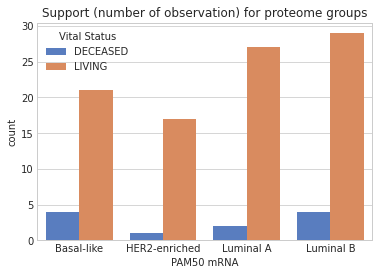

In [25]:
# Metastasis
sns.countplot(x='PAM50 mRNA', hue="Vital Status", data=clinical)
plt.title("Support (number of observation) for proteome groups")
plt.show()

In some of the groups, there is only 1-2 observations. I doubt we'll be able to get informative results.

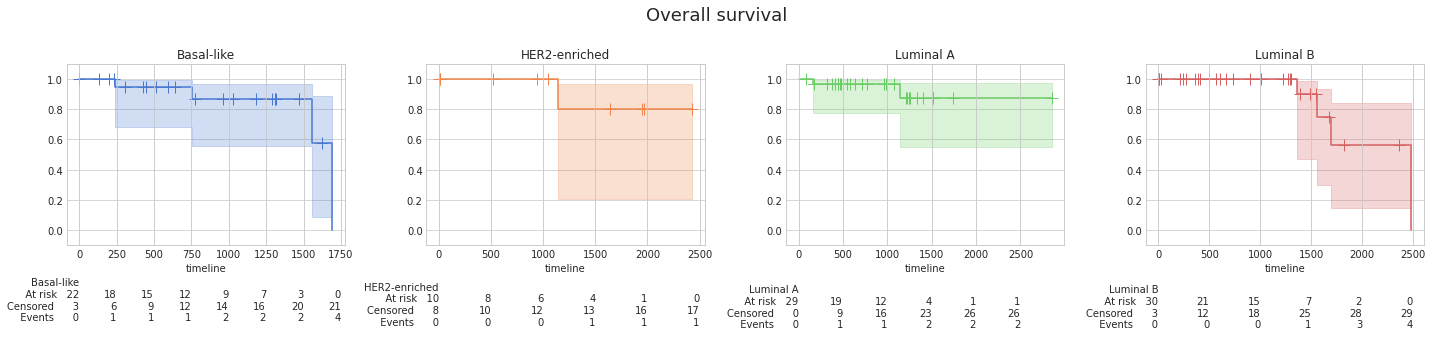

In [26]:
cat_vars_interest = ["PAM50 mRNA"]

T = clinical["OS Time"]
E = clinical["OS event"]

for c in cat_vars_interest:
    cat_names = clinical[c].unique()

    fig = plt.figure(figsize=(20,5))

    for i, cat_name in enumerate(cat_names):
        ax = plt.subplot(1, 4, i + 1)
        
        ix = clinical[c] == cat_name
        kmf = KaplanMeierFitter()
        kmf.fit(T[ix], E[ix], label=cat_name)
        kmf.plot_survival_function(ax=ax, legend=False, at_risk_counts=True, show_censors=True, loc=slice(0.,3000.), color=sns.color_palette("muted")[i])
        
        plt.title(cat_name)
        #plt.xlim(0, T.max())
        plt.ylim(-0.1,1.1)
        

        #if i==0:
        #    plt.ylabel('Frac. in power after $n$ years')

    #plt.title(c)
    #print(c)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    fig.suptitle("Overall survival", size=18, horizontalalignment="center")
    plt.show()

In [27]:
# Since the PAM50 m RNA variable is not ordinal, my opinion is that the use of a pairwise comparison of Kaplan-Meier curves is more appropriate.
from lifelines.statistics import pairwise_logrank_test
results = pairwise_logrank_test(
                event_durations = clinical["OS Time"], # T
                groups = clinical['PAM50 mRNA'],
                event_observed= clinical["OS event"], # E
                )
results.print_summary()
#are these p-vals corrected for multiple comparisons?

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                             test_statistic    p  -log2(p)
Basal-like    HER2-enriched            1.69 0.19      2.37
              Luminal A                1.26 0.26      1.94
              Luminal B                3.43 0.06      3.96
HER2-enriched Luminal A                0.07 0.79      0.33
              Luminal B                0.16 0.69      0.54
Luminal A     Luminal B                0.10 0.76      0.40

It looks like there is a statistically significant difference between Basal-like and Luminal B at an $\alpha=0.1$ level. 

# Discussion
1. Testing of the assumptions of the model should be performed.
1. I decided to use a liberal alpha threshold for the pairwise comparison only so that I can show a scheme for an analysis. Conventionally, an $\alpha$ threshold of 0.05 is used so these results wouldn't be considered statistically significant. They can, however, still be useful.